# Generate mask data files


In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd
import os

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
os.path.basename('NGC-star-clusters.fits')
dir_name=os.path.dirname('NGC-star-clusters.fits')
path=os.path.abspath('NGC-star-clusters.fits')
print(dir_name)
print(path)


/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits


In [3]:
# Escape backslashes by doubling them, explicitly indicating that they should be treated as literal characters.
mask_string ="/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits"
# mask_string = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/masking/gaia-mask-dr10.fits.gz"
print("Loading file...")
hdu = fits.open(mask_string, memmap=True)
hdu.info()

Loading file...
Filename: /Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     24   346R x 8C   [14A, 4A, 6A, D, D, D, D, D]   


In [4]:
print("File loaded. Assigning header and data...")
mask_header = hdu[1].header
mask_data = hdu[1].data


File loaded. Assigning header and data...


In [ ]:

print(mask_header)
print(mask_data['G_MAG_SB22'])
print(mask_data['BA'])
print(repr(mask_header))
# print header info

In [ ]:
#Doing a check of the data array sizes at ech step
mask_data_c=mask_data[(mask_data['G_MAG_SB22']<=21)&(mask_data['G_MAG_SB22']>=0)]
print(mask_data_c.shape)
mask_data_c = mask_data_c[mask_data_c['DEC'] < 30]
print(mask_data_c.shape)

In [ ]:
#check if any values that are not -1 are in the coloumn for G_MAG_SB22
#mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21)]
with np.printoptions(threshold=2000, suppress=False, linewidth=75):
    array=mask_data['G_MAG_SB22']
    non_neg_one=[]
    for i in range(0,len(array)):
        if array[i]>-1:
            non_neg_one.append(array[i])
    print(min(non_neg_one))
    print(max(non_neg_one))


In [ ]:
#Only extract rows with values in the magnitude column that meet the requirements 
mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21) & (mask_data['G_MAG_SB22']>=0)|(mask_data['R_MAG_SB22']<=21) & (mask_data['R_MAG_SB22']>=0)|(mask_data['Z_MAG_SB22']<=21) & (mask_data['Z_MAG_SB22']>=0)]
#mask_data_cut = mask_data[(mask_data['G_MAG_SB22']<=21) & (mask_data['G_MAG_SB22']>=0)]
print('G_Min is', min(mask_data_cut['G_MAG_SB22']))
print('G_Max is',max(mask_data_cut['G_MAG_SB22']))
print('R_Min is', min(mask_data_cut['R_MAG_SB22']))
print('R_Max is',max(mask_data_cut['R_MAG_SB22']))
print('Z_Min is', min(mask_data_cut['Z_MAG_SB22']))
print('Z_Max is',max(mask_data_cut['Z_MAG_SB22']))
print(mask_data_cut['G_MAG_SB22'][0:10])
print(mask_data_cut['R_MAG_SB22'][0:10])
print(mask_data_cut['Z_MAG_SB22'][0:10])

In [30]:
print("Dropping unneeded columns...(Retaining ra, dec, diam, ba, pa, g_mag_sb22, r_mag_sb22, z-mag_sb22)")
drop_fields = mask_data.names
allowed_fields = ['RA', 'DEC', 'RADIUS']
drop_fields = [field for field in drop_fields if field not in allowed_fields]
mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data, drop_fields)


Dropping unneeded columns...(Retaining ra, dec, diam, ba, pa, g_mag_sb22, r_mag_sb22, z-mag_sb22)


In [ ]:
# Cut out all stars at declinations above DEC
dec=30
print(f"Removing galaxies above DEC = {dec}")
mask_data_cut = mask_data_cut[mask_data_cut['DEC'] < dec]
print(mask_data_cut.shape)

# close everything
print("Data cleaned!")
hdu.close()
del hdu

print(max(mask_data_cut['R_MAG_SB22']))


In [6]:

np.savez_compressed(f'mask_data_clusters', mask_data_cut)

In [5]:
# WARNING this takes a long time (~4 min)

def generate_masked_stars(dec=30):
    """Generates a numpy file object of the masked stars
    
    DO NOT run this function unless absolutely necessary!!!!
    It takes ~4 minutes on its own excluding the amount of time needed to download
    the mask fits file.
    
    Parameters
    ----------
    dec: `float`
        Maximum declination to cut off the catalog at (default = 30)
    """
    
    mask_string = "/Users/vernica/Documents/GitHub/WiFeS_Catalog/NGC-star-clusters.fits"
    # mask_string = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/masking/gaia-mask-dr10.fits.gz"
    print("Loading file...")
    hdu = fits.open(mask_string, memmap=True)
    
    # hdu.info()
    print("File loaded. Assigning header and data...")
    mask_header = hdu[1].header
    mask_data = hdu[1].data

    # check if sources in desi and isbright / is medium
    print("Checking for bright/medium stars in DESI footprint...")
    #mask_data_cut = mask_data[(mask_data['isbright'] | mask_data['ismedium'])]

    # drop unneeded columns first
    print("Dropping unneeded columns...(Retaining ra, dec, radius)")
    drop_fields = mask_data.names
    allowed_fields = ['ra', 'dec', 'radius']
    drop_fields = [field for field in drop_fields if field not in allowed_fields]
    mask_data_cut = np.lib.recfunctions.rec_drop_fields(mask_data, drop_fields)
    
    # Cut out all stars at declinations above DEC
    print(f"Removing stars above DEC = {dec}")
    mask_data_cut = mask_data_cut[mask_data_cut['dec'] < dec]

    # close everything
    print("Data cleaned!")
    hdu.close()
    del hdu
    
    return mask_data_cut

mask_data_cut = generate_masked_stars()

Loading file...
File loaded. Assigning header and data...
Checking for bright/medium stars in DESI footprint...
Dropping unneeded columns...(Retaining ra, dec, radius)
Removing stars above DEC = 30
Data cleaned!


In [ ]:
# only consider stuff below a declination of 30

def generate_boxes(ra_interval, dec_interval):
    
    
    ra_ranges = np.arange(0, 360, ra_interval)
    dec_ranges = np.arange(-90, 30, dec_interval)

    print(ra_ranges)
    print(dec_ranges)
    
    mask_box = []
    
    for ra in ra_ranges:
        ra_bounds = (mask_data_cut['ra'] > ra) & (mask_data_cut['ra'] < ra+ra_interval)
        
        for dec in dec_ranges:
            dec_bounds = (mask_data_cut['dec'] > dec) & (mask_data_cut['dec'] < dec+dec_interval)
            
            print(f"RA: {ra}, DEC: {dec}")
            mask_box.append(mask_data_cut[ra_bounds & dec_bounds])
        
    return mask_box

mask_box = generate_boxes(70, 24)

In [ ]:
for i, box in enumerate(mask_box):
    print(f"Saving mask_data_{i}")
    np.savez_compressed(f'mask_data_{i}', box)
    
print("Done")

In [ ]:
fig, ax = plt.subplots()
# ax.plot(mask_data_cut['ra'], mask_data_cut['dec'])
ax.plot(mask_data_cut['ra'],mask_data_cut['dec'],'.')
# for box in mask_box:
#     ax.plot(box['RA'], box['DEC'], '.')
# ax.vlines(ra_ranges, ymin=-90, ymax=30, color='r')
# ax.hlines(dec_ranges, xmin=0, xmax=360, color='r')
plt.show()

In [54]:
cluster_masks = []

with np.load(f"mask_data_clusters.npz", mmap_mode='r') as mask_data:
    mask_array = mask_data['arr_0']
    mask_array_byteswap = mask_array.byteswap().newbyteorder()
    masked_stars = pd.DataFrame(mask_array_byteswap)
    cluster_masks.append(masked_stars)

In [61]:
cluster_masks
mask_df = pd.DataFrame(cluster_masks[0])
mask_df

,ra,dec,radius
0,6.022333,-72.081444,0.530000
1,6.701042,-71.535667,0.063333
2,11.764000,-11.871944,0.068000
3,13.197708,-26.589889,0.160000
4,13.300000,-73.000000,2.800000
...,...,...,...
302,325.091750,-23.179083,0.150000
303,329.896667,-39.385833,0.031330
304,337.410708,-20.837333,0.272167
305,346.685000,12.771000,0.020000


In [62]:
# remove points in the magellanic clouds and galactic plane
from astropy.coordinates import SkyCoord

c_icrs = SkyCoord(ra=mask_df['ra'], dec=mask_df['dec'], frame='icrs', unit='degree')
c_gal = c_icrs.galactic


In [63]:

for row, b in enumerate(c_gal.b.value):
    if abs(b) <= 19:
        mask_df = mask_df.drop(row)
        
mask_df = mask_df.reset_index(drop=True)


In [64]:

for n in range(len(mask_df)):
    if (mask_df['ra'][n] >= 76) and (mask_df['ra'][n] <= 86) and (mask_df['dec'][n] >= -76) and (mask_df['dec'][n] <= -64):
        mask_df = mask_df.drop(index=n)
    elif (mask_df['ra'][n] >= 11) and (mask_df['ra'][n] <= 16) and (mask_df['dec'][n] >= -76) and (mask_df['dec'][n] <= -70):
        mask_df = mask_df.drop(index=n)

mask_df = mask_df.reset_index(drop=True)

In [67]:
max(mask_df['radius'])

0.553

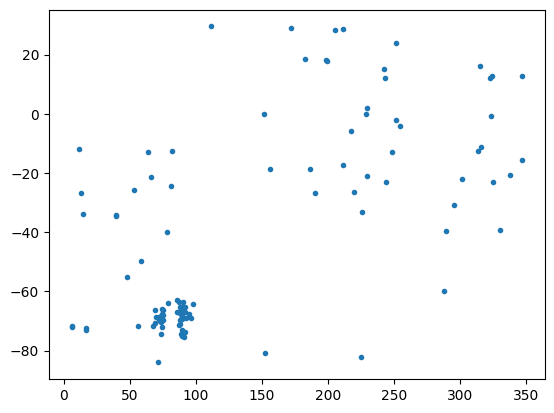

In [66]:
plt.plot(mask_df['ra'],mask_df['dec'],'.')

In [68]:
np.savez(f'mask_data_files/mask_data_clusters', mask_df)